(computing_derivatives)=

# Computing derivatives

heyoka.py provides two ways of computing the derivatives of an expression. The first one is the ``diff()`` function:

In [1]:
import heyoka as hy

x,y,z = hy.make_vars("x", "y", "z")

hy.diff(x + hy.cos(y*z), z)

-(y * sin((y * z)))

The ``diff()`` function implements symbolic differentiation of an expression with respect to a variable (or a parameter) via a straightforward application of the chain rule. Repeated applications of ``diff()`` can be used to compute higher-order derivatives.

The other way of computing derivatives in heyoka.py is the ``diff_tensors()`` function. ``diff_tensors()`` computes the full tensors of derivatives up to an arbitrary order. Let us see a simple example:

In [2]:
dt = hy.diff_tensors([x + hy.cos(y*z), hy.exp(x-z) + hy.log(y)],
                     diff_args=[x, y, z], diff_order=1)

Here we are asking for the derivatives of a 2-component vector-valued function with respect to all variables up to order 1. The value returned by ``diff_tensors()`` is an object of type ``dtens``. Let us explore it a bit:

In [3]:
dt

Highest diff order: 1
Number of outputs : 2
Diff arguments    : [x, y, z]

The screen output shows some general information: the derivative order, the number of outputs and the differentiation arguments. ``dtens`` objects have a length corresponding to the total number of derivatives stored within the object:

In [4]:
len(dt)

8

Here we have 8 derivatives in total: 2 order-0 derivatives (i.e., the original components of the function, which are returned in the ``dtens`` object) and 6 order-1 derivatives (3 for each component of the function).

``dtens`` is a dictionary-like ordered container mapping vectors of integral indices to derivatives. It is possible to iterate over the indices vectors, so that, e.g., we can build an ordered list of all the indices vectors in ``dt``:

In [5]:
list(dt)

[[0, 0, 0, 0],
 [1, 0, 0, 0],
 [0, 1, 0, 0],
 [0, 0, 1, 0],
 [0, 0, 0, 1],
 [1, 1, 0, 0],
 [1, 0, 1, 0],
 [1, 0, 0, 1]]

Each index vector begins with an index representing the function component. The remaining indices represent the derivative orders with respect to the variables. Thus, the index vector ``[1, 0, 1, 0]`` is used to indicate the first-order derivative of the second function component with respect to the second variable $y$.

Indices vector in a ``dtens`` object are sorted as follows:

- first, according to the total differentiation order in ascending order,
- then, according to the function component in ascending order,
- finally, in reverse lexicographic order with respect to the derivative orders for the differentiation arguments.

We can lookup specific derivatives via the square brackets operator. For instance, here is the first-order derivative of the second component with respect to $x$:

In [6]:
dt[1, 1, 0, 0]

{exp((x - z))}

Note that derivatives can be looked up by passing to the square brackets operator a vector of indices either in dense format (as we just did) or in sparse format. Sparse format means the only non-zero derivative indices are present in the vector:

In [7]:
dt[1, [(0, 1)]]

{exp((x - z))}

That is, in sparse format the square brackets operator takes in input a pair consisting of an integer (the function component) and a list of (variable index, diff order) pairs where the diff order is always nonzero. Sparse format performs better when working with first-order derivatives of functions with many variables, a situation in which dense indices vectors would be wastefully filled with zeroes.

We can check if a specific index vector appears in a ``dtens`` object via the ``in`` operator:

In [8]:
[3, 3, 3, 3] in dt

False

In [9]:
[3, [(0, 3)]] in dt

False

The ``get_derivatives()`` method can be used to fetch all derivatives for a specific total order. For instance, we can fetch the Jacobian from ``dt``:

In [10]:
dt.get_derivatives(diff_order=1)

[([0, 1, 0, 0], 1.0000000000000000),
 ([0, 0, 1, 0], {({z} * {-sin((y * z))})}),
 ([0, 0, 0, 1], {({y} * {-sin((y * z))})}),
 ([1, 1, 0, 0], {exp((x - z))}),
 ([1, 0, 1, 0], {y**-1.0000000000000000}),
 ([1, 0, 0, 1], {-{exp((x - z))}})]

We can also ask for the derivatives of a specific component. For instance, here's the gradient of the first component of the function:

In [11]:
dt.get_derivatives(diff_order=1, component=0)

[([0, 1, 0, 0], 1.0000000000000000),
 ([0, 0, 1, 0], {({z} * {-sin((y * z))})}),
 ([0, 0, 0, 1], {({y} * {-sin((y * z))})})]

```{versionadded} 3.1.0

```

The convenience properties ``gradient`` and ``jacobian`` can be used to access the gradient and Jacobian from a ``dtens`` object. For instance:

In [12]:
# Fetch from dt the Jacobian as a 2D array.
dt.jacobian

array([[1.0000000000000000, {({z} * {-sin((y * z))})},
        {({y} * {-sin((y * z))})}],
       [{exp((x - z))}, {y**-1.0000000000000000}, {-{exp((x - z))}}]],
      dtype=object)

## diff() vs diff_tensors()

``diff()`` and ``diff_tensors()`` both compute symbolic derivatives, and thus produce mathematically-equivalent results. However, the symbolic structure of the expressions returned by ``diff()`` and ``diff_tensors()`` can differ in ways that have a profound impact on the runtime complexity of the numerical evaluation of the derivatives.

``diff()`` always applies the chain rule in [forward mode](https://en.wikipedia.org/wiki/Automatic_differentiation#Forward_accumulation), and it also always applies the automatic simplifications described earlier in this tutorial. It is somewhat analogue to a pen-and-paper calculation.

By contrast, ``diff_tensors()`` may choose, depending on the function being differentiated and on the differentiation order, to perform symbolic differentiation in [reverse mode](https://en.wikipedia.org/wiki/Automatic_differentiation#Reverse_accumulation), rather than in forward mode. ``diff_tensors()`` also extensively uses ``fix()`` to {ref}`disable most automatic simplifications <ex_system_prev_simpl>` with the goal of producing symbolic expressions that are as close as possible to verbatim transcriptions of the forward/reverse mode automatic differentiation (AD) algorithms.

In order to clarify, let us show a concrete example where the differences between ``diff()`` and ``diff_tensors()`` matter a great deal. Speelpenning's function

$$
f\left(x_1, x_2, \ldots, x_n \right) = x_1\cdot x_2 \cdot \ldots \cdot x_n
$$

has often been used to ([incorrectly](https://arxiv.org/abs/1904.02990)) argue that numerical reverse-mode AD is superior to symbolic differentiation. Let us try to compute the gradient of this function first using ``diff()`` and then using ``diff_tensors()``.

We begin with the definition of the function (taking $n=8$):

In [13]:
sym_vars = [hy.expression(f"x_{i}") for i in range(1, 9)]
sp_func = hy.prod(sym_vars)
sp_func

(x_1 * x_2 * x_3 * x_4 * x_5 * x_6 * x_7 * x_8)

Now let us compute the gradient via ``diff()``:

In [14]:
grad_diff = [hy.diff(sp_func, v) for v in sym_vars]
grad_diff

[(x_2 * x_3 * x_4 * x_5 * x_6 * x_7 * x_8),
 (x_1 * x_3 * x_4 * x_5 * x_6 * x_7 * x_8),
 (x_1 * x_2 * x_4 * x_5 * x_6 * x_7 * x_8),
 (x_1 * x_2 * x_3 * x_5 * x_6 * x_7 * x_8),
 (x_1 * x_2 * x_3 * x_4 * x_6 * x_7 * x_8),
 (x_1 * x_2 * x_3 * x_4 * x_5 * x_7 * x_8),
 (x_1 * x_2 * x_3 * x_4 * x_5 * x_6 * x_8),
 (x_1 * x_2 * x_3 * x_4 * x_5 * x_6 * x_7)]

We can see how in the components of the gradient there are multiple repeated subexpressions. It is however unclear how one would select and isolate these common subexpressions with the goal of avoiding redundant computations - in general, this is a combinatorially-hard symbolic optimisation problem.

If we construct a compiled function for the evaluation of ``grad_diff`` and examine its decomposition, we can confirm that the number of operations needed to evaluate ``grad_diff`` scales quadratically $\operatorname{O}\left(n^2\right)$ with the number of variables:

In [15]:
grad_diff_cf = hy.make_cfunc(grad_diff, sym_vars)
grad_diff_cf.decomposition[8:-8]

[(u_0 * u_1 * u_2 * u_3 * u_4 * u_5 * u_6),
 (u_1 * u_2 * u_3 * u_4 * u_5 * u_6 * u_7),
 (u_0 * u_2 * u_3 * u_4 * u_5 * u_6 * u_7),
 (u_0 * u_1 * u_3 * u_4 * u_5 * u_6 * u_7),
 (u_0 * u_1 * u_2 * u_4 * u_5 * u_6 * u_7),
 (u_0 * u_1 * u_2 * u_3 * u_5 * u_6 * u_7),
 (u_0 * u_1 * u_2 * u_3 * u_4 * u_6 * u_7),
 (u_0 * u_1 * u_2 * u_3 * u_4 * u_5 * u_7)]

Now let us take a look at how ``diff_tensors()`` behaves instead:

In [16]:
# Compute the gradient via diff_tensors().
grad_diff_tensors = [t[1] for t in hy.diff_tensors([sp_func],
                                                   diff_args=hy.diff_args.vars,
                                                   diff_order=1).get_derivatives(1)]
grad_diff_tensors

[{({x_2} * {({((x_5 * x_6) * (x_7 * x_8))} * {(x_3 * x_4)})})},
 {({x_1} * {({((x_5 * x_6) * (x_7 * x_8))} * {(x_3 * x_4)})})},
 {({x_4} * {({((x_5 * x_6) * (x_7 * x_8))} * {(x_1 * x_2)})})},
 {({x_3} * {({((x_5 * x_6) * (x_7 * x_8))} * {(x_1 * x_2)})})},
 {({x_6} * {({(x_7 * x_8)} * {((x_1 * x_2) * (x_3 * x_4))})})},
 {({x_5} * {({(x_7 * x_8)} * {((x_1 * x_2) * (x_3 * x_4))})})},
 {({x_8} * {({(x_5 * x_6)} * {((x_1 * x_2) * (x_3 * x_4))})})},
 {({x_7} * {({(x_5 * x_6)} * {((x_1 * x_2) * (x_3 * x_4))})})}]

When computing the gradient of a multivariate scalar function, ``diff_tensors()`` automatically selects reverse-mode symbolic differentiation. We can see how the reverse-mode AD algorithm collects the terms in nested binary multiplications which occur multiple times in the gradient's components. The flattening of these binary multiplications is prevented by the use of the ``fix()`` function. As a consequence, when creating a compiled function for the evaluation of ``grad_diff_tensors``, the repeated subexpressions are recognised by heyoka.py (via a process of [common subexpression elimination](https://en.wikipedia.org/wiki/Common_subexpression_elimination)) and evaluated only once. Let us check:

In [17]:
grad_diff_tensors_cf = hy.make_cfunc(grad_diff_tensors, sym_vars)
grad_diff_tensors_cf.decomposition[8:-8]

[(u_0 * u_1),
 (u_2 * u_3),
 (u_4 * u_5),
 (u_6 * u_7),
 (u_8 * u_9),
 (u_10 * u_11),
 (u_11 * u_12),
 (u_10 * u_12),
 (u_13 * u_9),
 (u_13 * u_8),
 (u_5 * u_14),
 (u_4 * u_14),
 (u_7 * u_15),
 (u_6 * u_15),
 (u_1 * u_16),
 (u_0 * u_16),
 (u_3 * u_17),
 (u_2 * u_17)]

The total number of operations needed to evaluate the gradient has been reduced from 48 (via ``diff()``) to 18 (via ``diff_tensors()``). Indeed, we can show how the computational complexity of the evaluation of the gradient of Speelpenning's function via reverse-mode symbolic AD scales linearly $\operatorname{O}\left(n\right)$ with the number of variables:

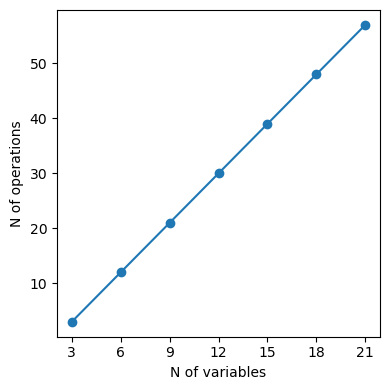

In [18]:
nops = []
nvars_list = [3, 6, 9, 12, 15, 18, 21]

for nvars in nvars_list:
    sym_vars = [hy.expression(f"x_{i}") for i in range(1, nvars+1)]
    sp_func = hy.prod(sym_vars)
    grad_diff_tensors = [t[1] for t in hy.diff_tensors([sp_func],
                                                       diff_args=hy.diff_args.vars,
                                                       diff_order=1).get_derivatives(1)]
    grad_diff_tensors_cf = hy.make_cfunc(grad_diff_tensors, sym_vars)
    nops.append(len(grad_diff_tensors_cf.decomposition) - 2*nvars)

%matplotlib inline
from matplotlib.pylab import plt

fig = plt.figure(figsize = (4, 4))

plt.plot(nvars_list, nops, 'o-')
plt.xticks(nvars_list)
plt.xlabel("N of variables")
plt.ylabel("N of operations")

plt.tight_layout();

This is clearly a marked improvement with respect to the quadratic complexity of the gradient computed via ``diff()``.

## General guidelines

In conclusion, how should one choose whether to use ``diff()`` or ``diff_tensors()`` to compute symbolic derivatives in heyoka.py?

In general, ``diff()`` should be used when the goal is to produce human-readable symbolic expressions, and when one wants to take advantage of heyoka.py's symbolic simplification capabilities.

If, however, the goal is to optimise the performance of the numerical evaluation of derivatives, then one should consider using ``diff_tensors()`` instead.